<a href="https://colab.research.google.com/github/Rtniewi/kcwiertniewicz-IDS/blob/main/Assignment4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

//***Katrina Cwiertniewicz
//*** CSC 330
//10/--/2024
//Assignment 4: Training a GAN on the LSUN Bedrooms Dataset
####The purpose of this assignment is to build and train a Generative Adversarial Network using the Large-scale Scene Understanding datasets' bedroom category. The goal is to train the GAN to generate realistic bedroom images based on the patterns learned from the training data.

# Setup

In [1]:
from google.colab import drive
import zipfile
import os

# First, mount Google Drive to access the file
drive.mount('/content/drive')

# Paths
zip_file_path = '/content/drive/My Drive/archive.zip'
extract_to = '/content/'

# Extract the filex
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify the extracted contents
os.listdir(extract_to)

# List the contents of the 'content' directory
os.listdir('/content')


Mounted at /content/drive


['.config', 'sample', 'data0', 'drive', 'sample_data']

In [2]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-eo_z1kuv
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-eo_z1kuv
  Resolved https://github.com/tensorflow/docs to commit 1e2f2d19d0f945707933a245be7a9715f0f07af0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.10.14.18741-py3-none-any.whl size=182607 sha256=7b0678a0d88856e640a9dc32f8fc7db80ce951d0c0c1233c29684cf27af290fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ifq9at8/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [24]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import random
from IPython import display
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    utils,
)

# Task 1: Load and Preprocess the LSUN Dataset

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
BUFFER_SIZE = 1000

In [5]:
train_images = tf.keras.preprocessing.image_dataset_from_directory(
   '/content/data0/lsun/bedroom',
    label_mode=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)
training_data=train_images

Found 303125 files belonging to 1 classes.


In [6]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

train = train_images.map(lambda x: preprocess(x))

In [7]:
# https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/utils.py
from google.colab import files
uploaded = files.upload()

from utils import display, sample_batch

train_sample = sample_batch(train)

Saving utils.py to utils.py


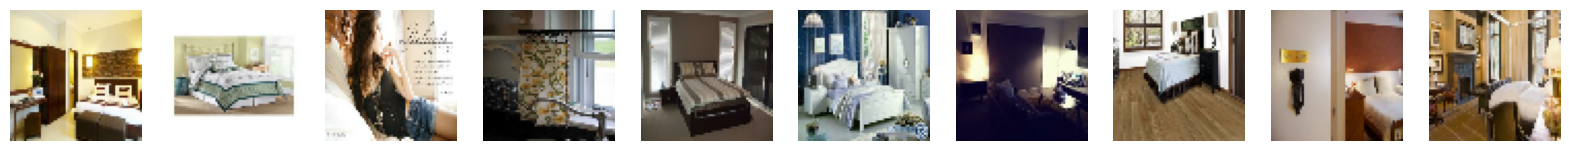

In [8]:
display(train_sample)

# Task 2: Create the Generator and Discriminator

### The Generator

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

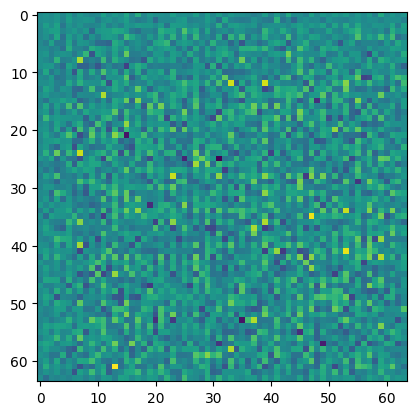

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### The Discriminator

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00129492]], shape=(1, 1), dtype=float32)


### Define the Loss and Optimizers

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save Checkpoints

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Task 3: Train the GAN

### Define the Training Loop

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
from tqdm import tqdm

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in tqdm(dataset):
    #for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### Generate and Save Images

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Train the Model

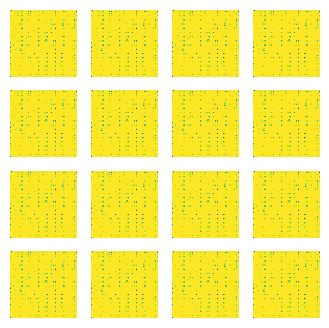

Time for epoch 11 is 684.3111925125122 sec


  7%|▋         | 698/9473 [00:50<10:51, 13.46it/s]

In [ ]:
train(train_images, EPOCHS)

Restore the Latest Checkpoint

In [1]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

NameError: name 'checkpoint' is not defined

### Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# Task 4: Use the generator to create new, previously unseen images of bedrooms that resemble the training data.
EPOCHS = 50
BATCH_SIZE = 256
noise_dim = 100
num_examples_to_generate = 16

